In [2]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

## Explore the digits data

In [3]:
digits = load_digits()
X = digits.data
np.shape(X)

(1797, 64)

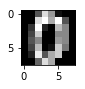

In [15]:
plt.figure(figsize=[1, 1]) # set the shown image size
plt.imshow(X[0, :].reshape((8, 8)), cmap="gray")
plt.show()

In [5]:
y = digits.target
print(np.shape(y))
y

(1797,)


array([0, 1, 2, ..., 8, 9, 8])

In [6]:
y = LabelBinarizer().fit_transform(y)
print(np.shape(y))
y

(1797, 10)


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
print("X_train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))
print("y_train: ", np.shape(y_train))
print("y_test: ", np.shape(y_test))

X_train:  (1257, 64)
X_test:  (540, 64)
y_train:  (1257, 10)
y_test:  (540, 10)


## Dropout + L2

We train a two-layer network, one hidden layer and one output layer. We have to redefine the `add_layer` function to return the weights so that we can compute the regularizer, and to include the dropout option.

In [80]:
def add_layer(inputs, in_size, out_size, keep_prob, activation_function = None):
    weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    wx_plus_b = tf.matmul(inputs, weights) + biases
    if activation_function is not None:
        output = activation_function(wx_plus_b)
        
    output = tf.nn.dropout(output, keep_prob)
    
    return output, weights

In [81]:
xs = tf.placeholder(tf.float32, [None, 64])
ys = tf.placeholder(tf.float32, [None, 10])
# Option to include dropout
keep_prob = tf.placeholder(tf.float32)

# Hidden layer with 50 units
l1, w1 = add_layer(xs, 64, 50, keep_prob, tf.nn.tanh)
prediction, w2 = add_layer(l1, 50, 10, 1., tf.nn.softmax) # No dropout in output layer!

# Loss with l2-regularization
alpha = 0.01
loss = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), axis = 1)) + alpha * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2))

# Optimizer
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [82]:
def compute_accuracy(predicted, original):
    return np.sum(np.argmax(predicted, axis = 1) == np.argmax(original, axis = 1)) / np.shape(predicted)[0]

In [89]:
train_loss, test_loss, train_accuracy, test_accuracy = ([], [], [], [])
steps = 1000
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    for i in range(steps):
        session.run(train_step, feed_dict = {xs: X_train, ys: y_train, keep_prob: 0.5})
        
        # NOTE: Only use dropout for the training steps. 
        # When we calculate the loss and prediction, don't use it, no matter for training set or test set
        train_loss.append(session.run(loss, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}))
        train_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}),
            y_train))
        test_loss.append(session.run(loss, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}))
        test_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}),
            y_test))

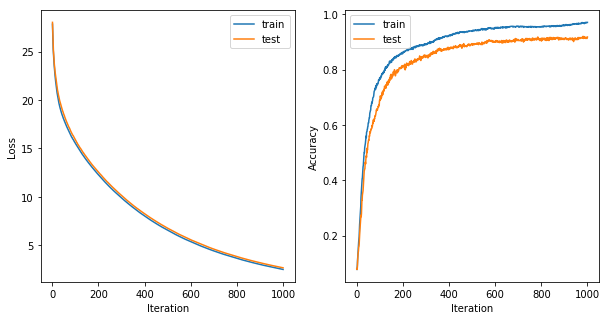

In [91]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(1, steps, steps), train_loss, label="train")
ax.plot(np.linspace(1, steps, steps), test_loss, label="test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend(loc = "best")

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(1, steps, steps), train_accuracy, label = "train")
ax.plot(np.linspace(1, steps, steps), test_accuracy, label = "test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.legend(loc = "best")

plt.show()

In [92]:
print("Train accuracy: ", train_accuracy[-1])
print("Test accuracy: ", test_accuracy[-1])

Train accuracy:  0.971360381862
Test accuracy:  0.918518518519


## For comparison: No regularization

In [93]:
loss = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), axis = 1))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

train_loss, test_loss, train_accuracy, test_accuracy = ([], [], [], [])
steps = 1000
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    for i in range(steps):
        session.run(train_step, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.})
        
        # NOTE: Only use dropout for the training steps. 
        # When we calculate the loss and prediction, don't use it, no matter for training set or test set
        train_loss.append(session.run(loss, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}))
        train_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}),
            y_train))
        test_loss.append(session.run(loss, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}))
        test_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}),
            y_test))

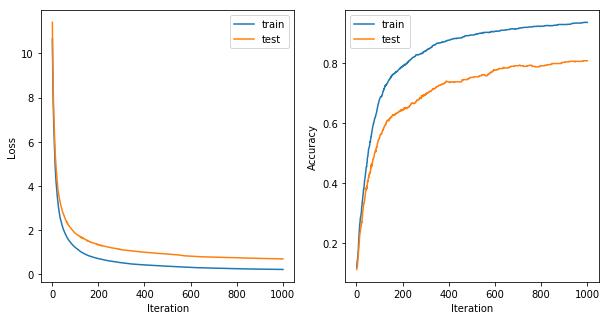

In [94]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(1, steps, steps), train_loss, label="train")
ax.plot(np.linspace(1, steps, steps), test_loss, label="test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend(loc = "best")

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(1, steps, steps), train_accuracy, label = "train")
ax.plot(np.linspace(1, steps, steps), test_accuracy, label = "test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.legend(loc = "best")

plt.show()

In [95]:
print("Train accuracy: ", train_accuracy[-1])
print("Test accuracy: ", test_accuracy[-1])

Train accuracy:  0.935560859189
Test accuracy:  0.807407407407


## For comparison: Only L2

In [96]:
alpha = 0.01
loss = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), axis = 1)) + alpha * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

train_loss, test_loss, train_accuracy, test_accuracy = ([], [], [], [])
steps = 1000
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    for i in range(steps):
        session.run(train_step, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.})
        
        # NOTE: Only use dropout for the training steps. 
        # When we calculate the loss and prediction, don't use it, no matter for training set or test set
        train_loss.append(session.run(loss, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}))
        train_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}),
            y_train))
        test_loss.append(session.run(loss, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}))
        test_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}),
            y_test))

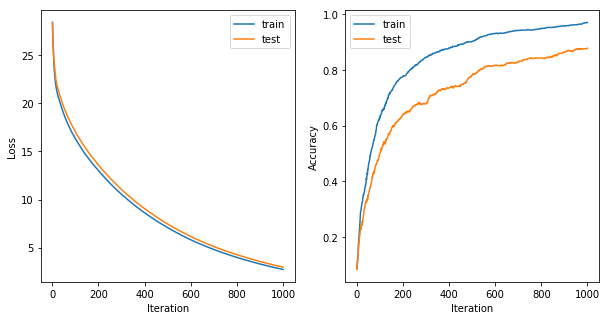

In [97]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(1, steps, steps), train_loss, label="train")
ax.plot(np.linspace(1, steps, steps), test_loss, label="test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend(loc = "best")

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(1, steps, steps), train_accuracy, label = "train")
ax.plot(np.linspace(1, steps, steps), test_accuracy, label = "test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.legend(loc = "best")

plt.show()

In [98]:
print("Train accuracy: ", train_accuracy[-1])
print("Test accuracy: ", test_accuracy[-1])

Train accuracy:  0.970564836913
Test accuracy:  0.877777777778


## For comparison: Only dropout

In [99]:
loss = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), axis = 1))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

train_loss, test_loss, train_accuracy, test_accuracy = ([], [], [], [])
steps = 1000
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    for i in range(steps):
        session.run(train_step, feed_dict = {xs: X_train, ys: y_train, keep_prob: 0.5})
        
        # NOTE: Only use dropout for the training steps. 
        # When we calculate the loss and prediction, don't use it, no matter for training set or test set
        train_loss.append(session.run(loss, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}))
        train_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_train, ys: y_train, keep_prob: 1.0}),
            y_train))
        test_loss.append(session.run(loss, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}))
        test_accuracy.append(compute_accuracy(
            session.run(prediction, feed_dict = {xs: X_test, ys: y_test, keep_prob: 1.}),
            y_test))

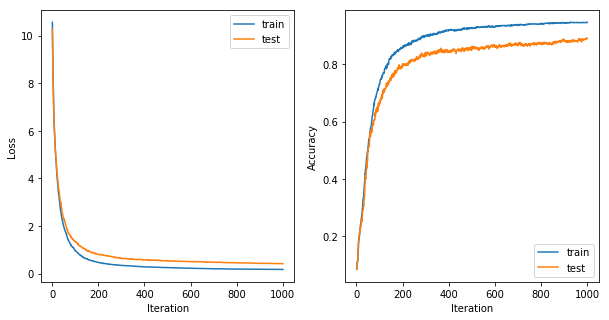

In [100]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(1, steps, steps), train_loss, label="train")
ax.plot(np.linspace(1, steps, steps), test_loss, label="test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend(loc = "best")

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(1, steps, steps), train_accuracy, label = "train")
ax.plot(np.linspace(1, steps, steps), test_accuracy, label = "test")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.legend(loc = "best")

plt.show()

In [101]:
print("Train accuracy: ", train_accuracy[-1])
print("Test accuracy: ", test_accuracy[-1])

Train accuracy:  0.945902943516
Test accuracy:  0.890740740741
